In [1]:
import json
import community
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

from glob import glob

import sys
sys.path.append('../../Data/auxiliary/')
from img_path import img_files

In [2]:
def replace_special_char(string):
    changes = [('á', 'a'), ('à', 'a'), ('â', 'a'), ('ã', 'a'),
               ('é', 'e'), ('ê', 'e'), ('í', 'i'), ('ó', 'o'),
               ('ô', 'o'), ('õ', 'o'), ('ú', 'u'), ('ç', 'c')]
    
    for change in changes: string = string.replace(change[0], change[1])
    return string

In [3]:
club_list = list()
for file in sorted(glob('../../Data/results/processed/Serie_A_*_games.json')):
    with open(file, 'rb') as f: data = json.load(f)
    for game in data:
        home_club = data[game]['Home']
        away_club = data[game]['Away']
        if home_club not in club_list: club_list.append(home_club)
        if away_club not in club_list: club_list.append(away_club)
        
club_list

['Vasco da Gama / RJ',
 'Portuguesa / SP',
 'Fluminense / RJ',
 'Athletico Paranaense / PR',
 'Corinthians / SP',
 'Botafogo / RJ',
 'Vitória / BA',
 'Internacional / RS',
 'Grêmio / RS',
 'Náutico / PE',
 'Ponte Preta / SP',
 'São Paulo / SP',
 'Criciúma / SC',
 'Bahia / BA',
 'Cruzeiro / MG',
 'Goiás / GO',
 'Coritiba / PR',
 'Atlético Mineiro / MG',
 'Santos / SP',
 'Flamengo / RJ',
 'Figueirense / SC',
 'Sport / PE',
 'Palmeiras / SP',
 'Chapecoense / SC',
 'Joinville / SC',
 'Avaí / SC',
 'Santa Cruz / PE',
 'América / MG',
 'Atlético / GO',
 'Paraná / PR',
 'Ceará / CE',
 'CSA / AL',
 'Fortaleza / CE',
 'Red Bull Bragantino / SP',
 'Cuiabá / MT',
 'Juventude / RS']

In [4]:
clubs_map = dict()
for club1 in club_list:
    clubs_map[club1] = dict()
    for club2 in club_list:
        clubs_map[club1][club2] = set()

for file in sorted(glob('../../Data/results/processed/Serie_A_*_squads.json')):
    year = int(file[-16:-12])
    if year == 2024: continue
    info_file = file.replace('squads', 'games')
    with open(file, 'rb') as f: data = json.load(f)
    with open(info_file, 'rb') as f: info = json.load(f)
    for game in data:
        home_club = info[game]['Home']
        away_club = info[game]['Away']
        for sub_game in data[game]:
            home_squad = set(data[game][sub_game]['Home']['Squad'])
            away_squad = set(data[game][sub_game]['Away']['Squad'])

            clubs_map[home_club][home_club] = clubs_map[home_club][home_club].union(home_squad)
            clubs_map[away_club][away_club] = clubs_map[away_club][away_club].union(away_squad)

            for player in home_squad:
                for club in clubs_map:
                    if home_club == club: continue
                    if player in clubs_map[club][club]:
                        clubs_map[club][home_club].add(player)

            for player in away_squad:
                for club in clubs_map:
                    if away_club == club: continue
                    if player in clubs_map[club][club]:
                        clubs_map[club][away_club].add(player)

for club1 in clubs_map:
    for club2 in clubs_map[club1]:
        clubs_map[club1][club2] = len(clubs_map[club1][club2])

clubs_inx = dict()
for i, club in enumerate(club_list): clubs_inx[club] = i

table = np.zeros((len(clubs_map), len(clubs_map)), dtype=int)
for club1 in clubs_map:
    i = clubs_inx[club1]
    for club2 in clubs_map:
        j = clubs_inx[club2]
        table[i, j] = clubs_map[club1][club2]


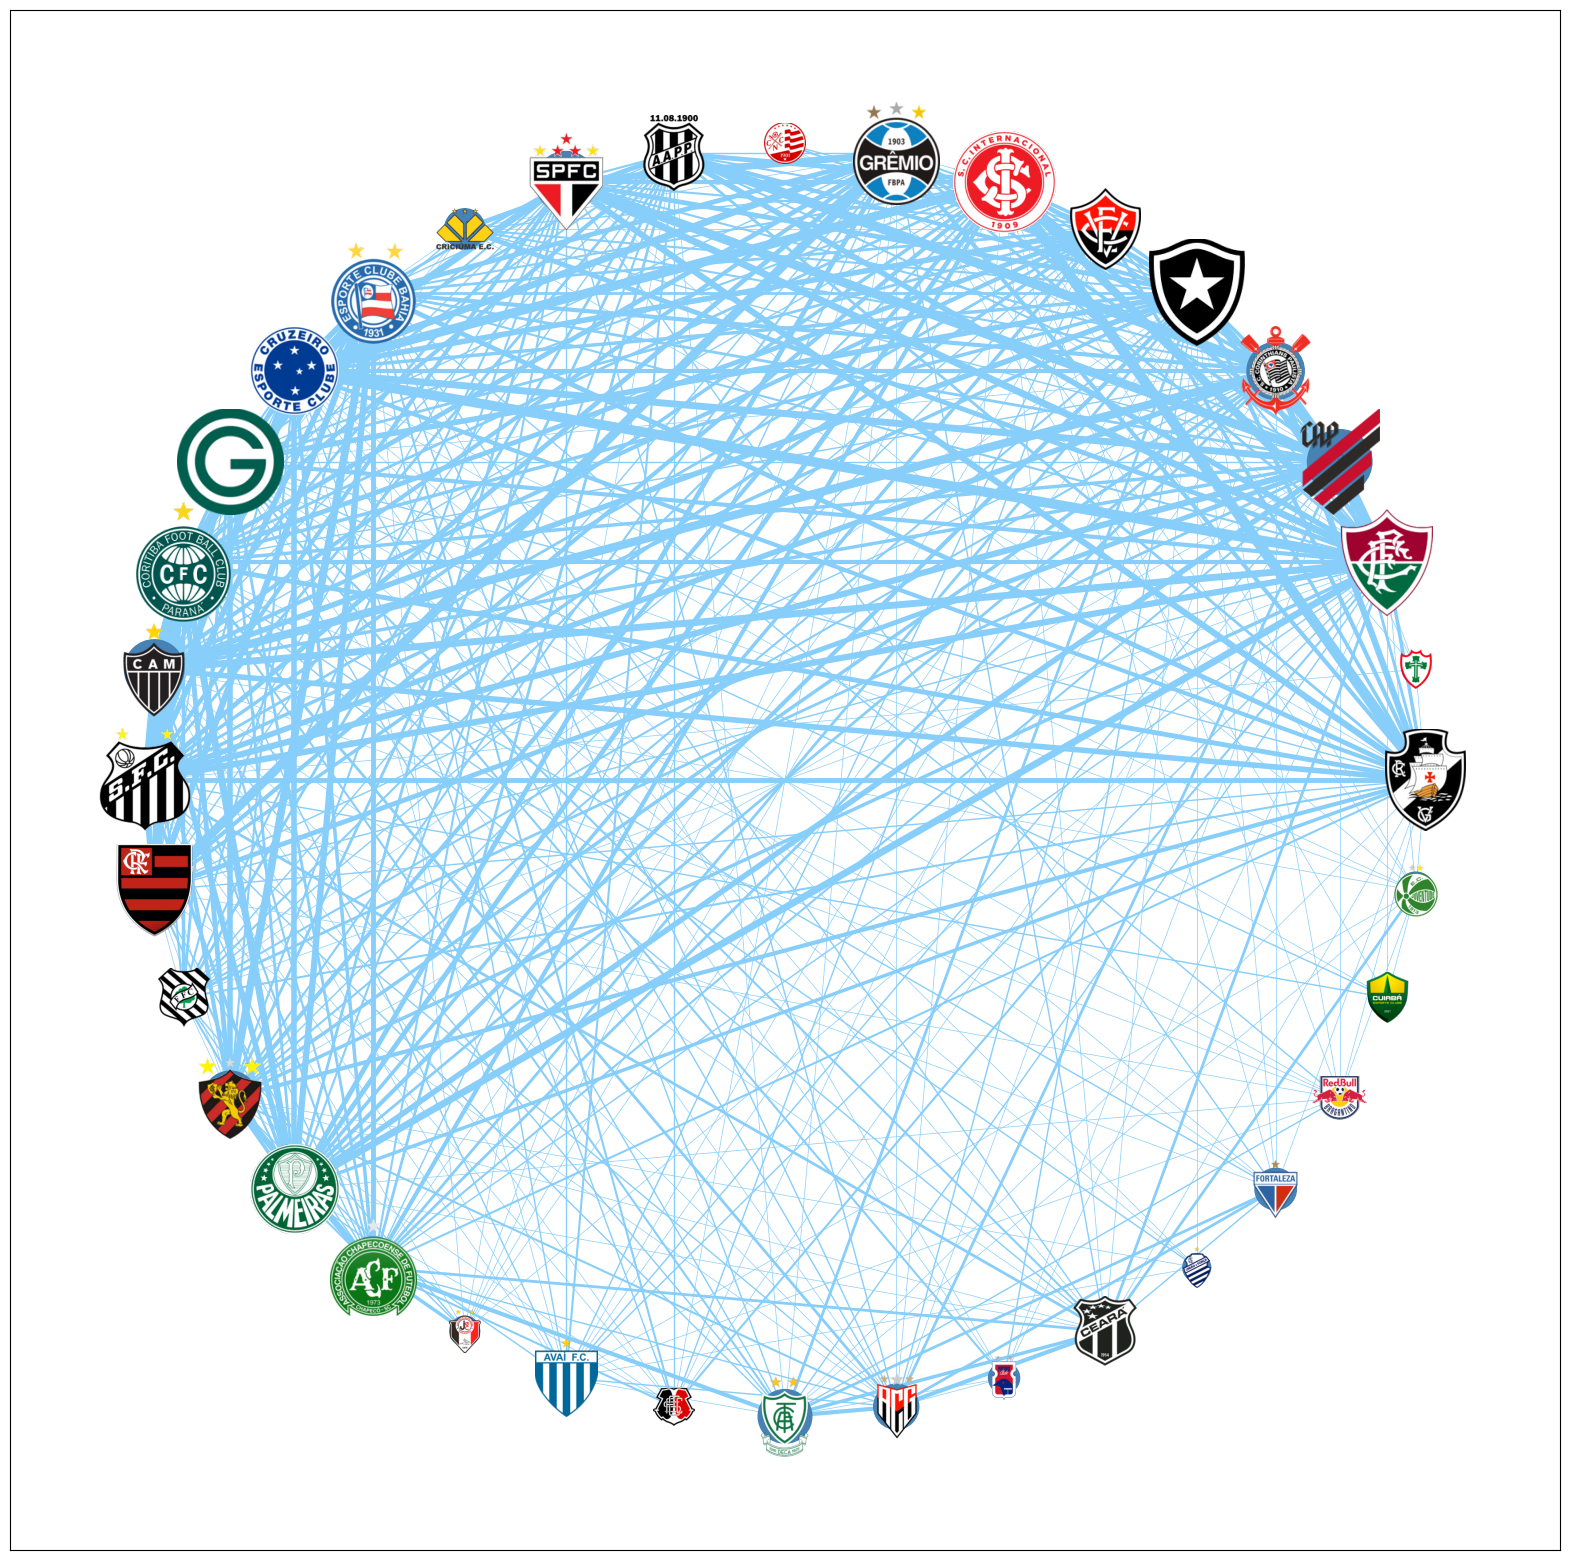

In [5]:
G = nx.Graph()
for club in clubs_inx:
    i = clubs_inx[club]
    G.add_node(i, color = 'steelblue', weight = table[i][i])

for club1 in clubs_inx:
    i = clubs_inx[club1]
    for club2 in clubs_inx:
        if club1 == club2: continue
        j = clubs_inx[club2]
        G.add_edge(i, j, color = 'lightskyblue', width = table[i][j])

inx_clubs = {value: key for key, value in clubs_inx.items()}

fig, ax = plt.subplots(figsize = (20, 20))
# pos = nx.spring_layout(G, scale = 1)
pos = nx.circular_layout(G)
nx.draw_networkx_edge_labels(G,
                             pos,
                             edge_labels = nx.get_edge_attributes(G, 'relation'),
                             label_pos = 1.5,
                             font_size = 9,
                             font_color = 'red',
                             font_family = 'sans-serif',
                             font_weight = 'normal',
                             alpha = 1.0,
                             bbox = None,
                             ax = ax,
                             rotate = True)

nx.draw_networkx(G,
                 pos = pos,
                 ax = ax,
                 node_color = [nx.get_node_attributes(G, 'color')[g] for g in G.nodes()],
                 edge_color = [nx.get_edge_attributes(G, 'color')[g] for g in G.edges()],
                 node_size = [nx.get_node_attributes(G, 'weight')[g] * 10 for g in G.nodes()],
                 width = [nx.get_edge_attributes(G, 'width')[g] * 0.5 for g in G.edges()])

trans = ax.transData.transform
trans2 = fig.transFigure.inverted().transform
weights = nx.get_node_attributes(G, 'weight')
w_max = 0
w_min = 1000
for club in weights:
    if weights[club] > w_max:
        w_max = weights[club]
    if weights[club] < w_min:
        w_min = weights[club]

dif = w_max - w_min
new = 0
relabel = {}
labels = {}
for g in G.nodes(): labels[g] = g
nx.draw_networkx_labels(G,
                        pos = pos,
                        labels = labels,
                        ax = ax,
                        font_color = 'steelblue')

for g in G.nodes():
    node = replace_special_char(inx_clubs[g]).replace(' ', '')
    img = mpimg.imread('../../' + img_files[node])
    weight = nx.get_node_attributes(G, 'weight')[g]
    imsize = (weight - w_min)/dif * 0.04 + 0.02
    (x, y) = pos[g]
    xx, yy = trans((x, y))
    xa, ya = trans2((xx, yy))
    a = plt.axes([xa - imsize / 2, ya - imsize / 2, imsize, imsize])
    a.imshow(img)
    a.set_aspect('equal')
    a.axis('off')


In [6]:
communities = community.best_partition(G)
print(f'We found a total of {max(communities.values()) + 1} community(ies)')

We found a total of 1 community(ies)
